In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy import stats
import scipy
import math
%matplotlib inline

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил  с 2021-11-29 по 2021-12-05 включительно. Для эксперимента были задействованы 0 и 1 группы.  

В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм в 1 группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста.

1. Выбрать метод анализа и сравнить CTR в двух группах.

2. Провести контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.

3. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.

In [2]:
# описываем соединение с БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}
# описываем sql запрос
q = """SELECT user_id, 
exp_group,
countIf(action='like') likes, 
countIf(action='view') views, 
likes / views ctr
FROM {db}.feed_actions 
where toDate(time) >= '2021-11-29' and toDate(time) <= '2021-12-05' and
exp_group in (1, 0)
group by user_id, exp_group
"""
# берем данные по sql запросу и кладем их df
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,4,13,0.307692
1,138232,1,41,166,0.246988
2,49204,1,39,134,0.291045
3,49286,1,6,61,0.098361
4,145957,1,46,202,0.227723


In [3]:
# оценим с помощью t-test есть ли статистически значимые различия между группами 0 и 1, по метрике ctr
t_test_result=stats.ttest_ind(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr, equal_var=False)
t_test_result

Ttest_indResult(statistic=-14.875024726684444, pvalue=7.822946546336658e-50)

считаем что группы отсплитованы достаточно хорошо

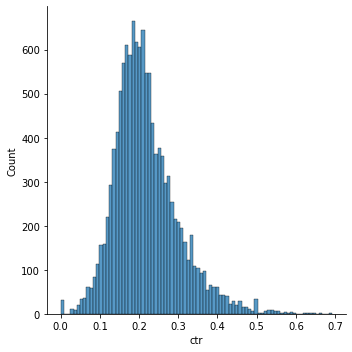

In [4]:
# посмторим распределение ctr в обеих подгруппах
sns.displot(df[df.exp_group == 0].ctr)

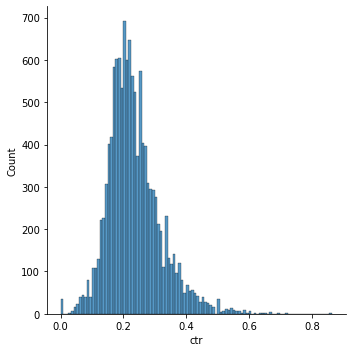

In [5]:
sns.displot(df[df.exp_group == 1].ctr)

In [20]:
# проверим наши распредения на нормальность
scipy.stats.shapiro(df[df.exp_group == 0].ctr)

/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9551162123680115, pvalue=0.0)

In [21]:
scipy.stats.shapiro(df[df.exp_group == 1].ctr)

ShapiroResult(statistic=0.9542357921600342, pvalue=0.0)

#### Согласно результатам тестов и визуальным наблюдениям наши распределения нельзя причислять к нормальным,
#### поэтому для оценки групп будем пользоваться непараметрическим критерием Манна-Витни

In [8]:
# за нулевую гипотезу возьмем предположение что между группами 0 и 1 нет статистически значимых различий 
# (т.е. нет разницы между новым и старым алгоритмами)
stats.mannwhitneyu(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr)

MannwhitneyuResult(statistic=68878160.0, pvalue=9.164668597899911e-61)

#### p-value "хорошо" меньше порога 0,05 следовательно наши группы 0 и 1 стастистичеки значимо различаются.

In [9]:
print ('Median/mean CTR в группе 0: ', round(df[df.exp_group == 0].ctr.median(),3), '/', round(df[df.exp_group == 0].ctr.mean(),3))
print ('Median/mean CTR в группе 1: ', round(df[df.exp_group == 1].ctr.median(),3), '/', round(df[df.exp_group == 1].ctr.mean(),3))

Median/mean CTR в группе 0:  0.206 / 0.218
Median/mean CTR в группе 1:  0.222 / 0.234


#### Глядя на значения CTR в тестовой и контрольной группах мы отмечаем повышение значения метрики при использовании нового алгоритма. Посмотрим не привело ли повышение CTR к падению/изменению входящих в его состав метрик.

In [10]:
print ('Median/mean likes в группе 0: ', round(df[df.exp_group == 0].likes.median(),3), '/', round(df[df.exp_group == 0].likes.mean(),3))
print ('Median/mean likes в группе 1: ', round(df[df.exp_group == 1].likes.median(),3), '/', round(df[df.exp_group == 1].likes.mean(),3))

Median/mean likes в группе 0:  13.0 / 15.85
Median/mean likes в группе 1:  14.0 / 16.919


In [11]:
print ('Median/mean views в группе 0: ', round(df[df.exp_group == 0].views.median(),3), '/', round(df[df.exp_group == 0].views.mean(),3))
print ('Median/mean views в группе 1: ', round(df[df.exp_group == 1].views.median(),3), '/', round(df[df.exp_group == 1].views.mean(),3))

Median/mean views в группе 0:  62.0 / 74.947
Median/mean views в группе 1:  62.0 / 74.391


#### Мы наблюдаем увеличение количества лайков при сохранении количества просмотров. Считаем что новый алгоритм, опробованный на группе 1, сотит того что бы быть реализованным на всех пользователей.

#### В тайне от руководства, на всякий случай что бы не уволили потом, проведем теже расчеты для "преобразованных" ctr-ов

In [12]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [13]:
global_ctr = df.likes.sum() / df.views.sum()
df['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr, 5), axis=1)
df['log_ctr'] = np.log(df.ctr+0.00001)

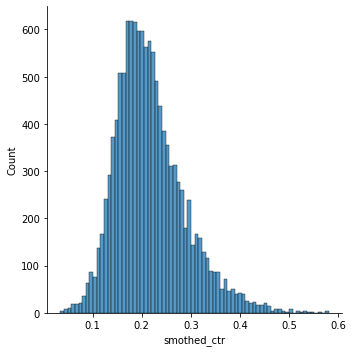

In [17]:
# посмотрим на получившиеся "преобразванные" распределения
sns.displot(df[df.exp_group == 0].smothed_ctr)

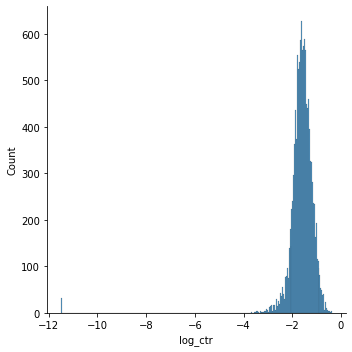

In [18]:
sns.displot(df[df.exp_group == 0].log_ctr)

In [19]:
# красиво и ближе к нормальному, но мы все-равно наблюдаем "хвосты", в одном случае справа в, другом слева
# поэтому так же пользуемся непараметрикой Манна-Витни

In [15]:
stats.mannwhitneyu(df[df.exp_group == 0].smothed_ctr, df[df.exp_group == 1].smothed_ctr)

MannwhitneyuResult(statistic=68696337.5, pvalue=4.585256224834548e-63)

In [56]:
stats.mannwhitneyu(df[df.exp_group == 0].log_ctr, df[df.exp_group == 1].log_ctr)

MannwhitneyuResult(statistic=68878160.0, pvalue=9.164668597899911e-61)

In [57]:
# 'преобразованные' ctr на тестах Манна-Витни так же показывают нам стат.значимые различия между группами 0 и 1 

#### Рапортуем о пригодности нового алгоритма и просим премию за непосильный труд.